## Phantom Simulation

In [1]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
from PIL import Image

### 0. Functions

In [2]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    shifted_array_vertical = np.roll(arr_in, ud_shift, axis=0) #vertical shift
    
    arr_out = np.roll(shifted_array_vertical, rl_shift, axis=1) #horizontal shift
    
    return np.array(arr_out, dtype = float)

In [3]:
def segment_image(img_in, lower_threshold, upper_threshold):
    
    lower_mask = (img_in >= lower_threshold).astype(np.uint8)
    upper_mask = (img_in <= upper_threshold).astype(np.uint8)
    
    binary_mask = np.logical_and(lower_mask, upper_mask).astype(np.uint8) # Combine the masks to get the final binary mask
    
    segmented_image = img_in * binary_mask # Segment out the pixels with the specified intensity range
    
    non_segmented_image = img_in * (1 - binary_mask)  # Invert the binary mask to get the pixels outside the specified range
    
    return segmented_image, non_segmented_image

In [4]:
def quantify_artifacts(ground_truth, img_in):
    
    binary_mask = (ground_truth != 0).astype(np.uint8)
    
    gt_cumulative_intensity = np.sum(ground_truth) #cumulative intensity of ground truth
    ip_cumulative_intensity = np.sum(img_in * binary_mask) #in place cumulative intensity of image
    oop_cumulative_intensity = np.sum(img_in * (1 - binary_mask)) #out of place cumulative intensity of image
    
    ip_ratio = ip_cumulative_intensity/gt_cumulative_intensity
    oop_ratio = oop_cumulative_intensity/gt_cumulative_intensity
    
    return ip_ratio, oop_ratio #in place and out of place ratio

### 1. Phantom Image Fourier Transform

In [5]:
#create 500*500 phantom image
phantom_img = sp.shepp_logan([256,256], float)

#Apply a 2D transformation on the image
phantom_kspace = np.fft.fftshift(np.fft.fft2(phantom_img))
magnitude_spectrum = np.log(np.abs(phantom_kspace) + 1) #Compute the magnitude spectrum (log-scaled for better visualization)
phase_spectrum = np.angle(phantom_kspace)

<function matplotlib.pyplot.show(close=None, block=None)>

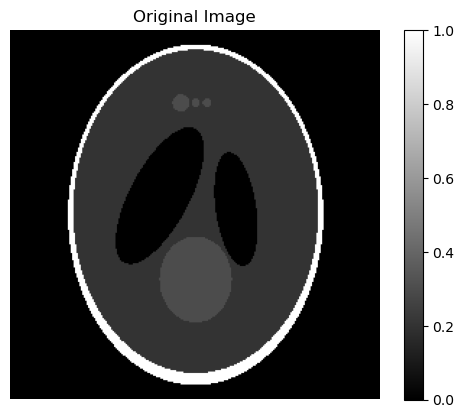

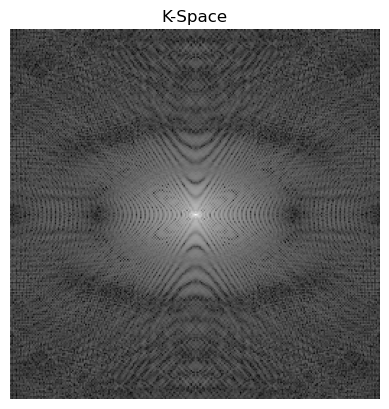

In [6]:
#plot phatom image in image space
plt.figure(1)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
plt.axis('Off')
colorbar = plt.colorbar()

#plot magnitude spectrum in k-space
plt.figure(2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('Off')
plt.title('K-Space')

plt.show

### 2. Phantom Image Spacial Shift and Effect in K-Space

In [7]:
#shift phantom image (simulate motion)
shifted_phantom_img = shift_2d_array(phantom_img,0,5)

<function matplotlib.pyplot.show(close=None, block=None)>

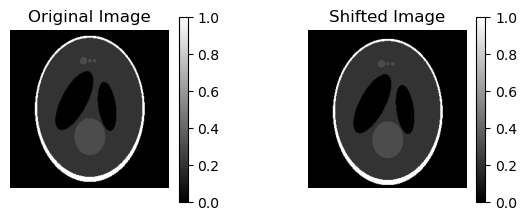

In [8]:
plt.subplot(121)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
colorbar = plt.colorbar(shrink=0.5)
plt.axis('Off')

#plot magnitude spectrum in k-space
plt.subplot(122)
plt.imshow(shifted_phantom_img, cmap='gray')
plt.title('Shifted Image')
colorbar = plt.colorbar(shrink=0.5)
plt.axis('Off')

plt.subplots_adjust(wspace=0.5)

plt.show

In [9]:
#Apply a 2D transformation on the shifted image
shifted_phantom_kspace = np.fft.fftshift(np.fft.fft2(shifted_phantom_img))
shifted_magnitude_spectrum = np.log(np.abs(shifted_phantom_kspace) + 1)
shifted_phase_spectrum = np.angle(shifted_phantom_kspace)

#Calculate phase difference
phase_product = shifted_phantom_kspace * np.conj(phantom_kspace)
phase_difference = np.angle(phase_product)

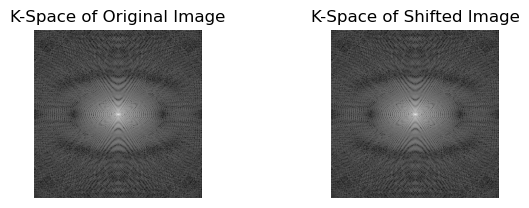

In [10]:
plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('K-Space of Original Image')
plt.axis('Off')


#plot magnitude spectrum in k-space
plt.subplot(222)
plt.imshow(shifted_magnitude_spectrum, cmap='gray')
plt.title('K-Space of Shifted Image')
plt.axis('Off')

plt.subplots_adjust(wspace=0.5)

In [11]:
# print(shifted_magnitude_spectrum)

(-0.5, 255.5, 255.5, -0.5)

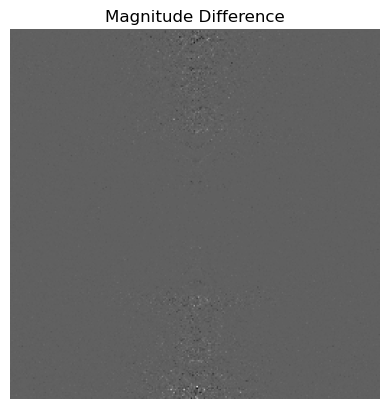

In [12]:
magnitude_difference = shifted_magnitude_spectrum - magnitude_spectrum
# print(magnitude_difference)

plt.figure()
plt.imshow(magnitude_difference, cmap='gray')
plt.title('Magnitude Difference')
plt.axis('Off')

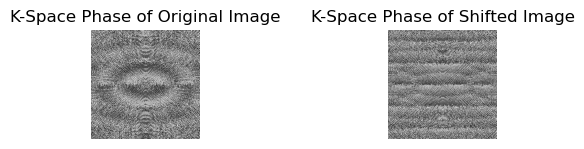

In [13]:
plt.subplot(321)
plt.imshow(phase_spectrum, cmap='gray')
plt.title('K-Space Phase of Original Image')
plt.axis('Off')


#plot magnitude spectrum in k-space
plt.subplot(322)
plt.imshow(shifted_phase_spectrum, cmap='gray')
plt.title('K-Space Phase of Shifted Image')
plt.axis('Off')


plt.subplots_adjust(wspace=0.5)

(-0.5, 255.5, 255.5, -0.5)

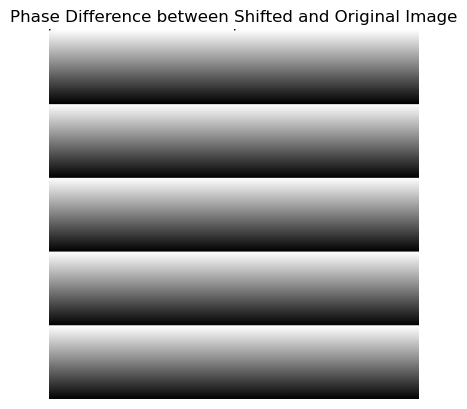

In [14]:
plt.figure()
plt.imshow(phase_difference, cmap='gray')
plt.title('Phase Difference between Shifted and Original Image')
plt.axis('Off')

Absolute value of k-space should be exactly the same for the original and shifted image\
Only the phase of k-space should look different - difference between the 2 images should show a phase ramp

### 3. Periodic Motion Simulation

3D stack of images, additional time scale, 20 frames of images in 1 cardiac cycle, sample sequencially in k-space, then do inverse fourier transform

Displacement: sinusoidal approximation of motion

#### 3.1 Segmentation

In this part, the Shepp Logan phantom will be segmented into 2 images, with the segmented pixels representing the ones that experience motion, and the rest with no motion.

In [15]:
original_img = sp.shepp_logan([256,256], float)
print(np.unique(original_img))

lower_threshold = np.float64(0.299)
upper_threshold = np.float64(0.301)

lower_mask = (original_img >= lower_threshold).astype(np.uint8)
upper_mask = (original_img <= upper_threshold).astype(np.uint8)

segmented_img, non_segmented_img = segment_image(original_img, lower_threshold, upper_threshold)

[-5.55111512e-17  0.00000000e+00  2.00000000e-01  3.00000000e-01
  1.00000000e+00]


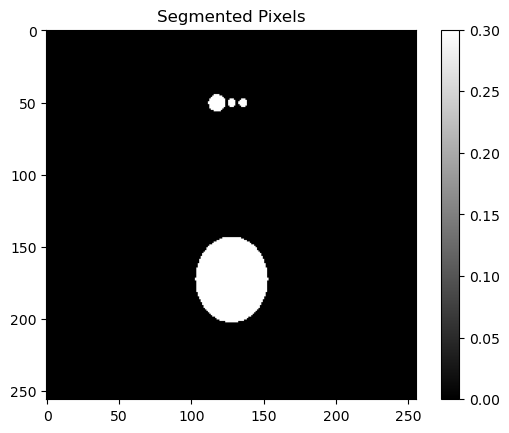

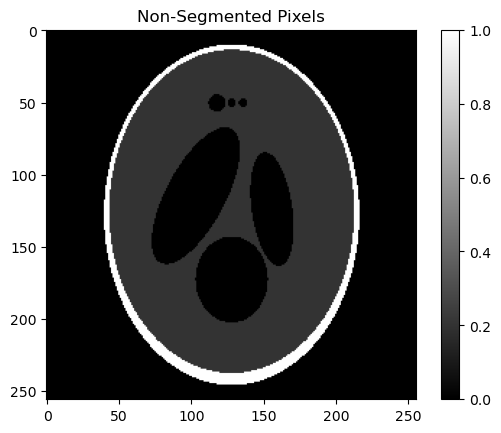

In [16]:
plt.figure()
plt.imshow(segmented_img, cmap='gray')
plt.title('Segmented Pixels')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(non_segmented_img, cmap='gray')
plt.title('Non-Segmented Pixels')
colorbar = plt.colorbar()

#### 3.2 Image Space Oscillation

The amplitude of oscillation should be a few pixels/voxels to reflect the pulses in the brain stem.

In [17]:
# Create a 3d array along the timescale of a stack of 2D images with shifts characterised by a sinusoidal pattern
num_frames = 121

frequency = 20

t = np.linspace(0, 2 * np.pi * frequency, num_frames)

img_stack_segment = np.zeros((256, 256, num_frames)) #20 256*256 images - initialise array
kspace_stack_segment = np.zeros((256, 256, num_frames), dtype=np.complex128) #hard coded, need to fix
kspace_mag_stack_segment = np.zeros((256, 256, num_frames))

img_stack = np.zeros((256, 256, num_frames))

img_stack_non_segment = np.zeros((256, 256, num_frames)) #20 256*256 images - initialise array
kspace_stack_non_segment = np.zeros((256, 256, num_frames), dtype=np.complex128) #hard coded, need to fix
kspace_mag_stack_non_segment = np.zeros((256, 256, num_frames))

for i in range(num_frames):
    
    #shift pixels and conduct Fourier transform of the segmented images
    shift = np.round(3*np.sin(t[i])).astype(int)
    img_stack_segment[:,:,i] = shift_2d_array(segmented_img, 0, shift)
    kspace_stack_segment[:,:,i] = np.fft.fftshift(np.fft.fft2(img_stack_segment[:,:,i]))
    
    #create resultant image
    img_stack[:,:,i] = img_stack_segment[:,:,i] + non_segmented_img
#     kspace_mag_stack_segment[:,:,i] = np.log(np.abs(kspace_stack_segment[:,:,i]) + 1)
    
    #conduct Fourier transform of the non-segmented images
    img_stack_non_segment[:,:,i] = shift_2d_array(non_segmented_img, 0, shift)
    kspace_stack_non_segment[:,:,i] = np.fft.fftshift(np.fft.fft2(img_stack_non_segment[:,:,i]))
    kspace_mag_stack_non_segment[:,:,i] = np.log(np.abs(kspace_stack_non_segment[:,:,i]) + 1)
    
    
    
def update_2d_frame(frame_index):
    plt.imshow(img_stack[:,:,frame_index], cmap='gray')
    plt.title(f'Frame {frame_index}')
    plt.axis('Off')
    plt.show()
    
frame_slider = widgets.IntSlider(value=0, min=0, max=img_stack_segment.shape[2]-1, description='Frame') #create slider
widgets.interactive(update_2d_frame, frame_index=frame_slider)

#Uncomment to see phase spectrum

# plt.figure()
# plt.imshow(img_stack_segment[:,:,20], cmap='gray')

# def update_2d_frame_kspace(frame_index):
#     plt.imshow(kspace_mag_stack[:,:,frame_index], cmap='gray')
#     plt.title(f'Frame {frame_index}')
#     plt.axis('Off')
#     plt.show()
    
# frame_slider = widgets.IntSlider(value=0, min=0, max=img_stack_segment.shape[2]-1, description='Frame') #create slider
# widgets.interactive(update_2d_frame_kspace, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=120), Output()), _dom_classes=('widget-inter…

#### 3.3 Flow motion resulting in phase oscillation in phase encoding direction in k-space

In [18]:
#Apply a sinusoidal phase modification across segment k-space frames
x = np.arange(0, 256)
y = np.arange(0, 256)
xx, yy = np.meshgrid(x, y)

phase_oscillation_amplitude = np.pi #apply phase quadratic term
phase_oscillation_frequency = 20 

# phase_modification = np.zeros((256,256,num_frames))

for i in range(num_frames):
    phase_modification = phase_oscillation_amplitude * np.sin(2 * np.pi * phase_oscillation_frequency * i / num_frames)
    kspace_stack_segment[:,:,i] = kspace_stack_segment[:,:,i] * np.exp(1j * phase_modification)

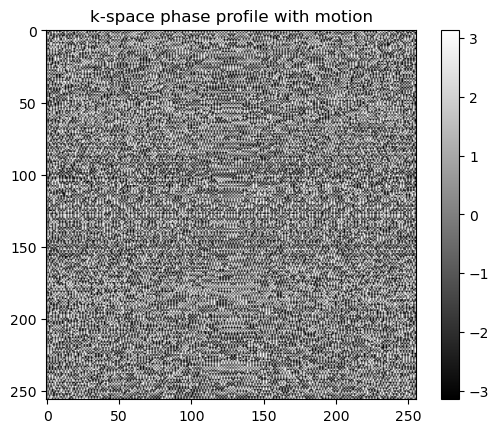

In [24]:
#Sample k-space from stack
sampled_segment_kspace = np.zeros((256,256), dtype=np.complex128)

frame_index = 0

for row in range(np.shape(kspace_stack_segment)[0]):
    current_frame = kspace_stack_segment[:,:,frame_index]
    sampled_segment_kspace[row,:] = current_frame[row,:]
#     print('Filled row ' + str(row) + ' with row ' + str(row) + ' of frame ' + str(frame_index))
    
    if (row + 1) % (np.floor(num_frames/frequency).astype(int)) != 0:
        frame_index += 1
    else:
        frame_index = 0

sampled_segment_kspace_mag = np.log(np.abs(sampled_segment_kspace) + 1)
sampled_segment_kspace_phase = np.angle(sampled_segment_kspace)

# plt.figure()
# plt.imshow(sampled_segment_kspace_mag, cmap='gray')
# plt.title('k-space magnitude profile with motion')
# print(np.abs(sampled_kspace))

plt.figure()
plt.imshow(sampled_segment_kspace_phase, cmap='gray')
plt.title('k-space phase profile with motion')
colorbar = plt.colorbar()

# plt.figure()
# plt.imshow(np.angle(kspace_stack_segment[:,:,0]), cmap='gray')
# plt.title('k-space phase profile - original')

# phase_product_conj = sampled_kspace_phase * np.conj(np.angle(kspace_stack_segment[:,:,0]))
# phase_diff_motion = np.angle(phase_product_conj)

# plt.figure()
# plt.imshow(phase_diff_motion, cmap='gray')
# plt.title('k-space phase profile difference')

Apply phase oscillation to the segment

In [25]:
# #apply phase oscillation to the segment in the PE (phase encoding) direction

# #create 2D array with oscillation in the vertical dimension
# x = np.arange(0, 256)
# y = np.arange(0, 256)
# xx, yy = np.meshgrid(x, y)

# phase_oscillation_amplitude = np.pi #apply phase quadratic term
# phase_oscillation_frequency = 20 
# phase_modification = phase_oscillation_amplitude * np.sin(2 * np.pi * phase_oscillation_frequency * yy / 256)

# sampled_segment_kspace = sampled_segment_kspace * np.exp(1j * phase_modification) #apply angle (phase) modification

# sampled_segment_kspace_mag = np.log(np.abs(sampled_segment_kspace) + 1)
# sampled_segment_kspace_phase = np.angle(sampled_segment_kspace)

# #construct resultant k-space stack

# plt.figure()
# plt.imshow(phase_modification, cmap='gray')
# colorbar = plt.colorbar()

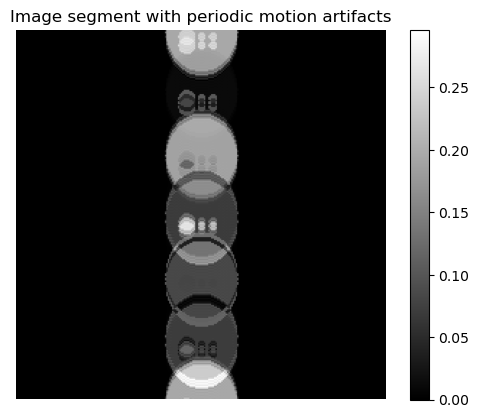

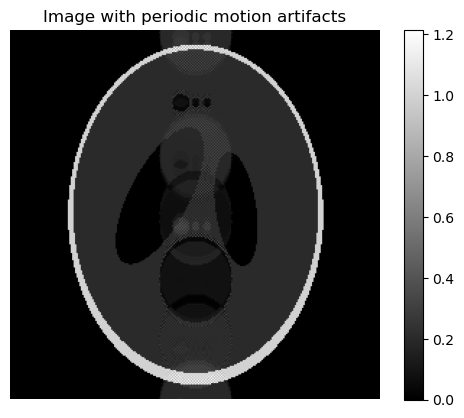

In [26]:
sampled_segment_img = np.fft.ifftn(sampled_segment_kspace)
sampled_img = non_segmented_img + sampled_segment_img

plt.figure()
plt.imshow(np.abs(sampled_segment_img), cmap='gray')
plt.title('Image segment with periodic motion artifacts')
plt.axis('Off')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(np.abs(sampled_img), cmap='gray')
plt.title('Image with periodic motion artifacts')
plt.axis('Off')
colorbar = plt.colorbar()

### 4. Periodic Motion Correction

Try averaging randomly vs averaging over 1 cycle

In [27]:
average_segment_img = np.mean(img_stack_segment[:,:,:20], axis=2)

average_img_cycle = np.mean(img_stack[:,:,:20], axis=2) #image averaged over a cycle
average_img_non_cycle = np.mean(img_stack[:,:,:35], axis=2) #image averaged randomly

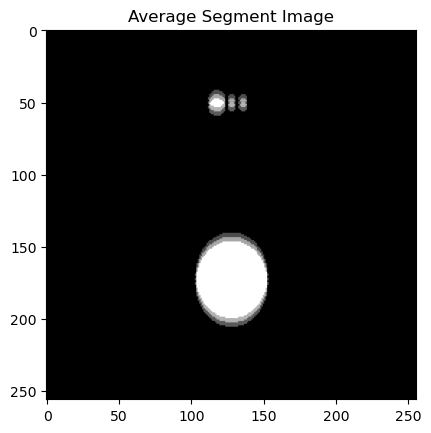

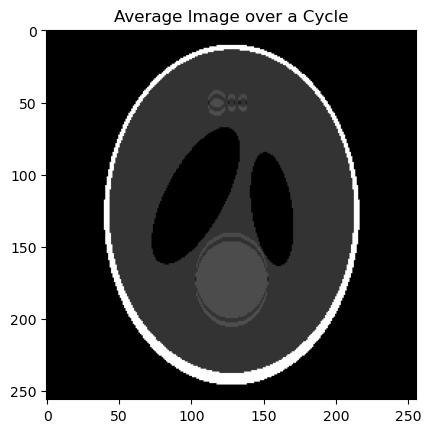

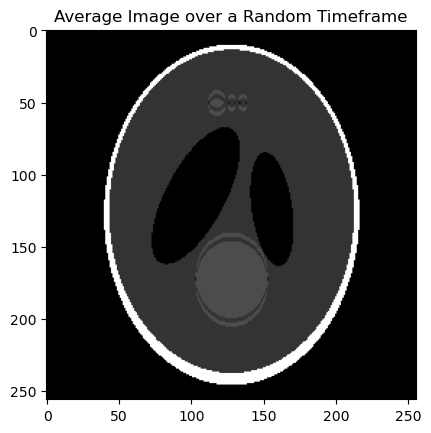

In [28]:
plt.imshow(average_segment_img, cmap='gray')
plt.title('Average Segment Image')
plt.show()

plt.imshow(average_img_cycle, cmap='gray')
plt.title('Average Image over a Cycle')
plt.show()

plt.imshow(average_img_non_cycle, cmap='gray')
plt.title('Average Image over a Random Timeframe')
plt.show()

### 5. Quantify Motion Artefacts

The percentage of cumulative pixel intensity in place will be used to quantify the effectiveness of motion correction.

In [29]:
ip_ratio, oop_ratio = quantify_artifacts(segmented_img, average_segment_img)
print(ip_ratio, oop_ratio)

0.9432746196957567 0.05672538030424339


In [ ]:
#0.9476381104883906 0.05236188951160928

Plot barchart

Text(0, 0.5, 'Ratio')

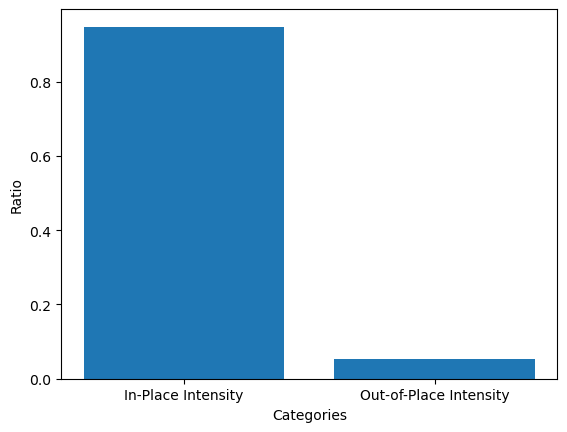

In [40]:
categories = ['In-Place Intensity', 'Out-of-Place Intensity']
values = [ip_ratio, oop_ratio]

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Ratio')

In [39]:
# Feb - averaging and bloch simulation
# March - 
# April - data needed collected 
# May - ISMRM
# June - 


In [ ]:
# 3/5, 17, 29 May Exams